In [1]:
import torch

In [2]:
import os
from PIL import Image
import glob

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

In [3]:
class Br35H(Dataset):

    def read_dataset(self):

        images_path = self.images_path
        masks_path = self.masks_path
        imgs =  glob.glob(images_path + "/*.jpg")
        masks = glob.glob(masks_path + "/*.png")

        return imgs, masks, len(imgs)

    def __init__(self, images_path,masks_path, transforms=None):
        self.images_path = images_path
        self.masks_path= masks_path
        self.images, self.masks, self.length= self.read_dataset()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = image.convert("RGB")
        
        mask = Image.open(self.masks[index]).convert('L')

        #mask = image.convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            

        return image, mask

    def __len__(self):
        return self.length

In [4]:
transforms_train = transforms.Compose([transforms.Resize((256, 256)),
                                      #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

transforms_valid = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor()])

In [5]:
train_dataset = Br35H(cfg.TRAIN_IMAGE_PATH, cfg.TRAIN_ANNOT_DIR, transforms_train)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = Br35H(cfg.VAL_IMAGE_PATH,cfg.VAL_ANNOT_DIR,transforms=transforms_valid)
validloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
       
        return logits



In [9]:
model = UNet (3,1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [11]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [12]:
loss_list = []
accuracy_list = []

In [13]:
torch.cuda.empty_cache()

In [14]:
def binary_acc(y_pred, y_test):
   y_pred_tag = torch.round(torch.sigmoid(y_pred))

   correct_results_sum = (y_pred_tag == y_test).sum().float()
   acc = correct_results_sum/y_test.shape[0]
   acc = torch.round(acc * 100)

   return acc

In [15]:
for epoch in range (20):
    
    running_loss = 0.0
    nb_data = 0.
    for i, data in enumerate(trainloader, 0):

        inputs, masks = data
        optimizer.zero_grad()
        inputs, masks = inputs.to(device), masks.to(device)
      
        outputs = model(inputs)             
        
        
        loss = criterion(outputs, masks)
        loss.backward()                    
        optimizer.step()                   
 
        
        running_loss += loss.item()
        
        nb_data += 1.
        
    running_loss = running_loss / nb_data
    loss_list.append(running_loss)

    correct = 0.
    total = 0.

 
    
    print("Epoch ", epoch, "; train loss = ", running_loss
          
          )

Epoch  0 ; train loss =  0.2384042337536812
Epoch  1 ; train loss =  0.18301856661587954
Epoch  2 ; train loss =  0.180567003428936
Epoch  3 ; train loss =  0.17917705644667148
Epoch  4 ; train loss =  0.17834585969895125
Epoch  5 ; train loss =  0.17779272198677062
Epoch  6 ; train loss =  0.17657354431599379
Epoch  7 ; train loss =  0.175581097997725
Epoch  8 ; train loss =  0.17472890056669713
Epoch  9 ; train loss =  0.17428339894115924
Epoch  10 ; train loss =  0.1733972232416272
Epoch  11 ; train loss =  0.172507582873106
Epoch  12 ; train loss =  0.17172085232287645
Epoch  13 ; train loss =  0.1716382447257638
Epoch  14 ; train loss =  0.17050435692071914
Epoch  15 ; train loss =  0.1699250363484025
Epoch  16 ; train loss =  0.16916833809763193
Epoch  17 ; train loss =  0.168451658166945
Epoch  18 ; train loss =  0.16736729235202075
Epoch  19 ; train loss =  0.1669541872292757


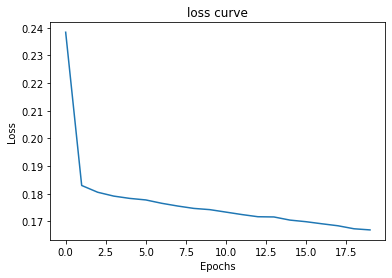

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot()
plt.plot(range(len(loss_list)), loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss curve")

plt.show()